In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.io import read_raw_egi

import mypy

Używamy komendy `cd` aby wejść do folderu, w którym mieszkają dane

In [2]:
cd C:\Users\Ola\Dropbox\Sarenka\warsztaty python\eeg

C:\Users\Ola\Dropbox\Sarenka\warsztaty python\eeg


In [3]:
pwd

'C:\\Users\\Ola\\Dropbox\\Sarenka\\warsztaty python\\eeg'

# Wczytujemy dane

In [4]:
fls = os.listdir()
fls

['grupa1war.fdt',
 'grupa1war.set',
 'grupa1warsztatyeeg 20160221.raw',
 'grupa2warsztatyeeg 20160221.raw']

In [5]:
# widzimy powyżej pliki .fdt .set i .raw - chcemy tylko raw, pomoże nam list comprehension:
fls = [f for f in fls if f.endswith('.raw')]
fls

['grupa1warsztatyeeg 20160221.raw', 'grupa2warsztatyeeg 20160221.raw']

In [6]:
eeg = read_raw_egi(fls[0], preload=True)

Reading EGI header from grupa1warsztatyeeg 20160221.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
Reading 0 ... 104678  =      0.000 ...   418.712 secs...


In [7]:
eeg

<RawEGI  |  grupa1warsztatyeeg 20160221.raw, n_channels x n_times : 68 x 104679 (418.7 sec)>

# Zmagania z plotowaniem
Najpierw ustawmy wsparcie dla matplotlib'a w notebook'u:

In [8]:
%matplotlib

Using matplotlib backend: Qt4Agg


In [9]:
eeg.plot();

W komórce powyżej próbowaliśmy wyplotować dane, jednak oczom naszym ukazał się mrok i groza. Jak sobie z tym poradzić? Rozwiązanie jest całkiem proste, ale najpierw wyjaśnię z czego wynika problem. Niestety metoda `.plot()` nie skaluje domyślnie sygnału, więc w pewnych sytuacjach skala jest koszmarnie zła. Możemy jednak podać odpowiednią skalę jako słownik: `typ kanału -> skala`:

In [10]:
skala = {'eeg': 20}
eeg.plot(scalings=skala, show=False);

Ok, widzimy sygnał, trzeba go jednak jeszcze przefiltrować. Na zajęciach robiliśmy to krok po kroku, ale teraz zrobimy to w jednej linijce:

# Preprocessing - filtrowanie, dodawanie eventów, pozycji elektrod

In [11]:
eeg_flt = eeg.copy().filter(1, None).filter(53,47)

High-pass filtering at 1 Hz
Band-stop filtering from 47 - 53 Hz


In [12]:
eeg_flt.plot(scalings=skala);

In [13]:
# dodajemy eventy z wykorzystaniem pakietu mypy:
mypy.events.din2event(eeg_flt); # ta operacja jest in-place tzn. bez kopii

In [14]:
eeg_flt.info

<Info | 17 non-empty fields
    bads : 'list | 0 items
    buffer_size_sec : 'float | 1.0
    ch_names : 'list | EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, ...
    chs : 'list | 65 items (EEG: 65)
    comps : 'list | 0 items
    custom_ref_applied : 'bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : 'numpy.ndarray | 138 items
    filename : 'str | .../grupa1warsztatyeeg 20160221.raw
    highpass : 'float | 1.0 Hz
    hpi_meas : 'list | 0 items
    hpi_results : 'list | 0 items
    lowpass : 'float | 125.0 Hz
    meas_date : 'numpy.ndarray | 2016-02-21 12:18:24
    nchan : 'int | 65
    projs : 'list | 0 items
    sfreq : 'float | 250.0 Hz
    acq_pars : 'NoneType
    acq_stim : 'NoneType
    ctf_head_t : 'NoneType
    description : 'NoneType
    dev_ctf_t : 'NoneType
    dig : 'NoneType
    experimenter : 'NoneType
    file_id : 'NoneType
    hpi_subsystem : 'NoneType
    line_freq : 'NoneType
    meas_id : 'NoneType
    proj_id : 'NoneType
    p

In [15]:
eeg_flt.info['events'][:10,:]

array([[2992,    0,    8],
       [3722,    0,    4],
       [4453,    0,    8],
       [5186,    0,    8],
       [5914,    0,    8],
       [6649,    0,    4],
       [7374,    0,    4],
       [8117,    0,    8],
       [8840,    0,    4],
       [9561,    0,    4]])

In [16]:
# możemy wyplotować sygnał z informacją o wydarzeniach tak:
kolory = {4: 'g', 8: 'r'}
eeg_flt.plot(events=eeg_flt.info['events'], event_color=kolory, show=False, scalings=skala);

In [17]:
# dodajemy pozycję elektrod
from mne.channels import read_montage

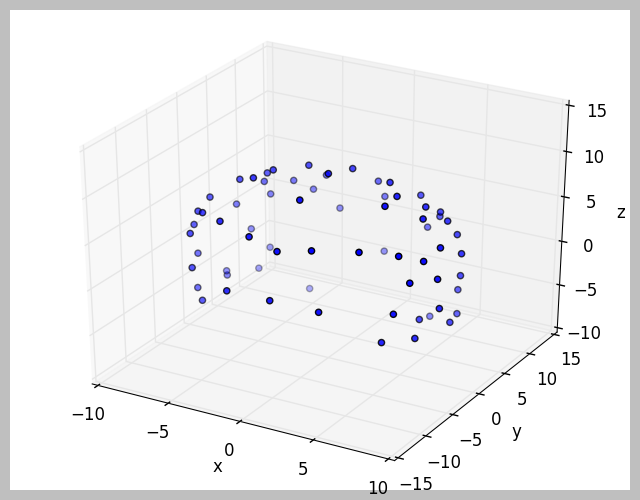

In [18]:
mntg = read_montage('GSN-HydroCel-65_1.0')
mntg.plot()

In [19]:
print(mntg.ch_names[:8])
print(mntg.ch_names[-4:])

['FidN', 'FidT', 'FidT', 'E1', 'E2', 'E3', 'E4', 'E5']
['E62', 'E63', 'E64', 'Cz']


In [20]:
# nie zgadza się to z nazewnictwem elektrod jakie mamy obecnie w eeg:
print(eeg_flt.ch_names[:8])
print(eeg_flt.ch_names[-4:])

['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008']
['EEG 062', 'EEG 063', 'EEG 064', 'EEG 065']


Niestety nazwy elektrod się nie zgadzają...
Musimy je zmienić - pomoże nam metoda `rename_channels` obiektu `Raw`:

In [21]:
# tworzymy słownik mapowań stara nazwa --> nowa nazwa
map_names = {ch: 'E' + str(int(ch[-3:])) for ch in eeg_flt.ch_names[:-1]}
map_names['EEG 065'] = 'Cz'
for k in list(map_names.keys())[:5]:
    print('{}: {}'.format(k, map_names[k]))

EEG 031: E31
EEG 024: E24
EEG 042: E42
EEG 030: E30
EEG 040: E40


In [22]:
# zmieniamy nazwy
eeg_flt.rename_channels(map_names)

In [23]:
print(eeg_flt.ch_names[:8])
print(eeg_flt.ch_names[-4:])

['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8']
['E62', 'E63', 'E64', 'Cz']


In [24]:
# możemy spokojnie ustawić teraz montaż
eeg_flt.set_montage(mntg)

In [25]:
# zobacznmy jakie elektrody są gdzie
eeg_flt.plot_sensors(show=False);

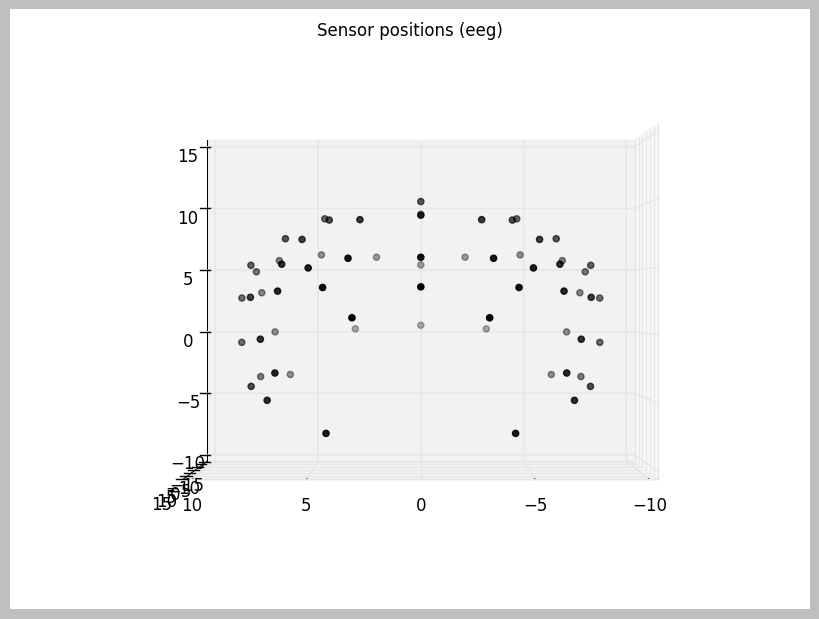

In [26]:
# a tak wygląda to w 3d:
eeg_flt.plot_sensors(kind='3d', show=False)

# Preprocessing: epokowanie, odrzucanie epok, ica

In [27]:
# tworzymy epoki względem wydarzeń twarz i samochód
ev_dict = {'face': 4, 'car': 8}
ep = mne.Epochs(eeg_flt, events=eeg_flt.info['events'], event_id=ev_dict, tmin=-0.25, tmax=0.75, preload=True)

138 matching events found
Applying baseline correction (mode: mean)
Adding average EEG reference projection.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 138 events and 251 original time points ...
0 bad epochs dropped


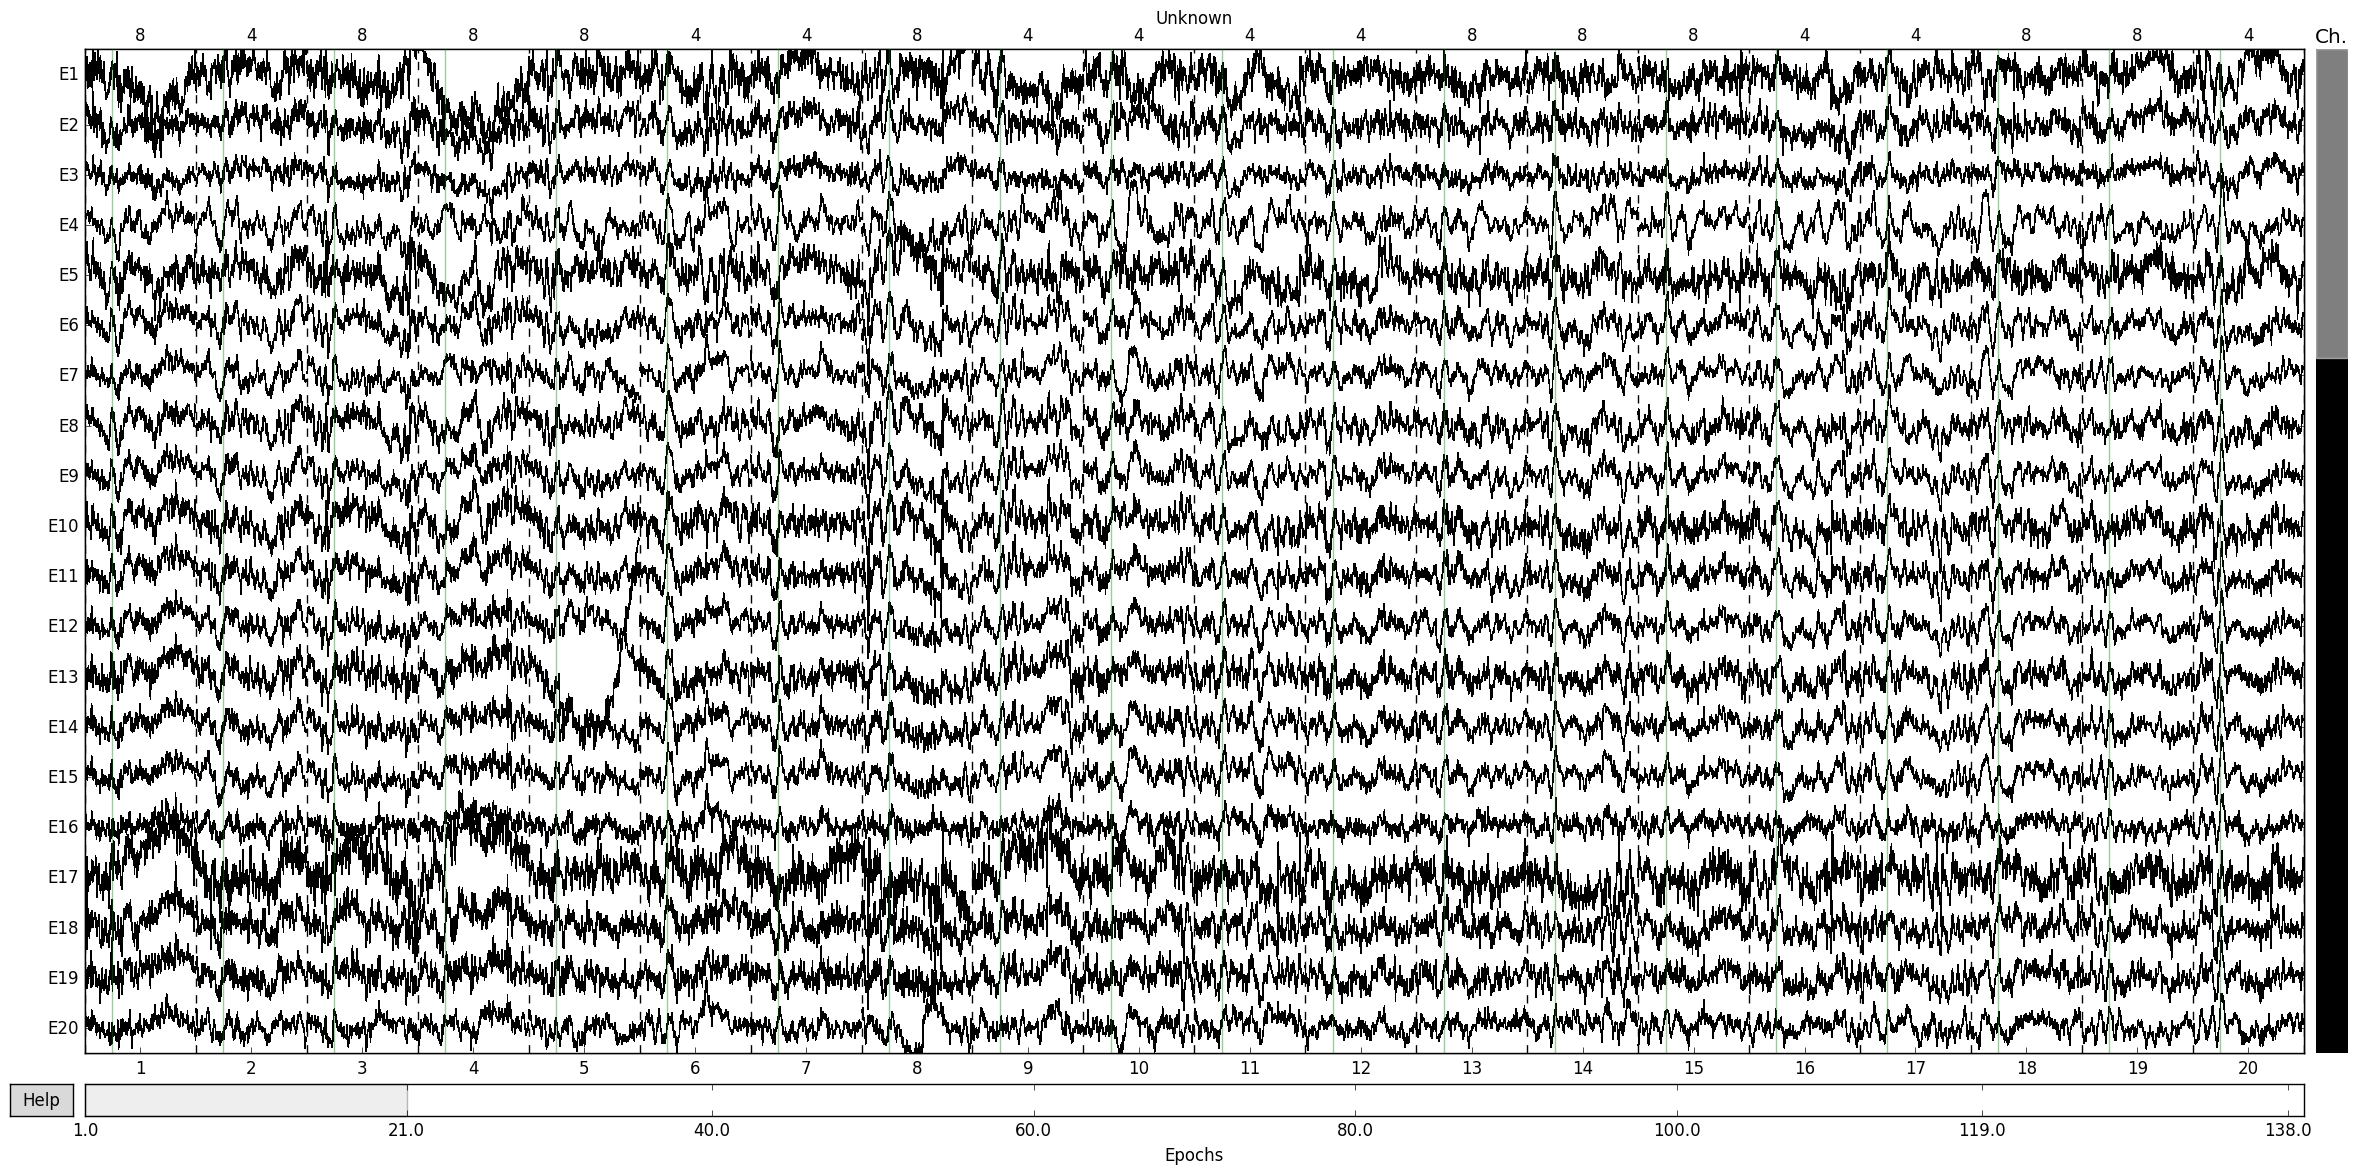

Dropped 1 epoch
Channels marked as bad: []


In [30]:
# przeglądamy epoki, odrzucamy epoki zaśmiecone artefaktami
ep.plot(scalings=skala)

Z opisu wyniżej wnioskujemy, że jedna epoka została usunięta. Zróbmy sobie jeszcze kilka wizualizacji:

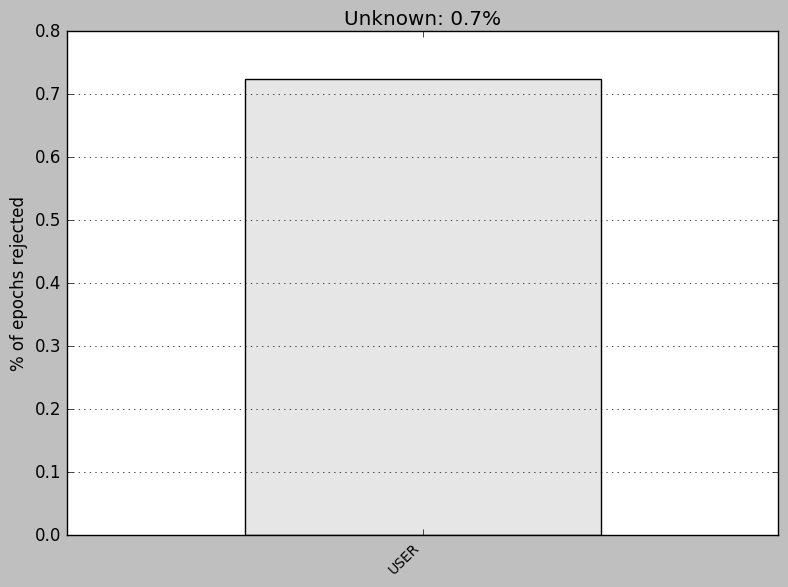

In [32]:
ep.plot_drop_log()

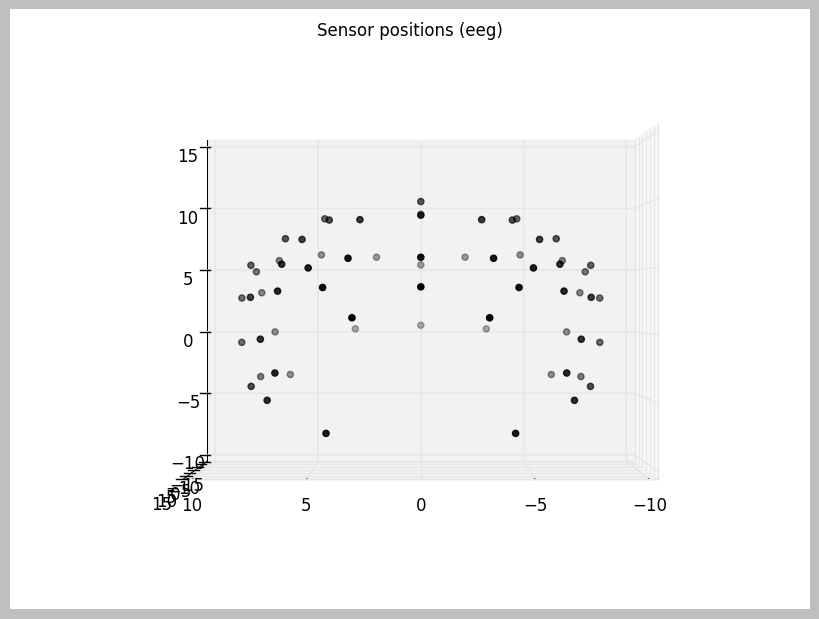

In [34]:
# wybierzmy sobie jakąś elektrodę (albo nawet dwie-trzy)
ep.plot_sensors(kind='3d')

In [35]:
ch = 'E36'
ch_ind = ep.ch_names.index(ch)
print('elektroda {} jest {} z kolei w liście wszystkich elektrod'.format(ch, ch_ind))

elektroda E36 jest 35 z kolei w liście wszystkich elektrod


In [38]:
ep.plot_image(ch_ind)

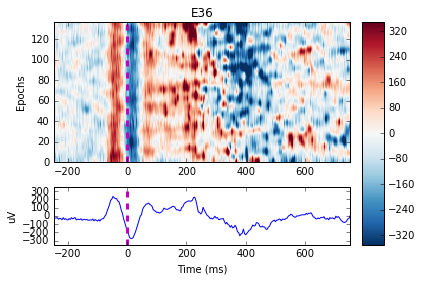

In [47]:
%matplotlib inline
ep.plot_image(ch_ind, sigma=3, scalings=skala, vmin=-350, vmax=350)

Using matplotlib backend: Qt4Agg


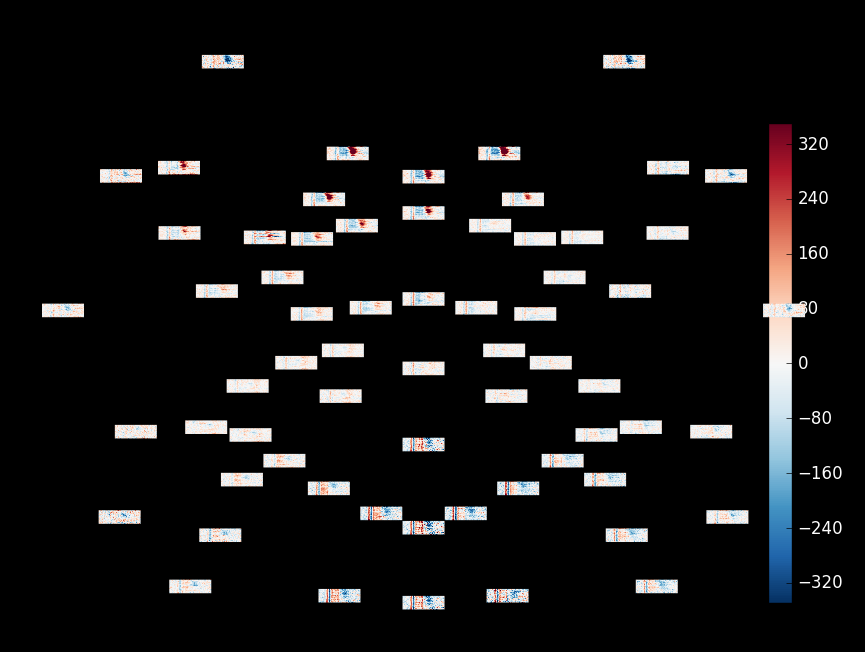

In [54]:
%matplotlib
ep.plot_topo_image(sigma=3, scalings=skala, vmin=-350, vmax=350)

## ICA

In [50]:
from mne.preprocessing import ICA
ica = ICA(method='extended-infomax', n_components=0.98, max_iter=380)

In [51]:
ica.fit(ep)

Fitting ICA to data using 65 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Selection by explained variance: 29 components
computing Extended Infomax ICA


<ICA  |  epochs decomposition, fit (extended-infomax): 34387 samples, 29 components, channels used: "eeg">

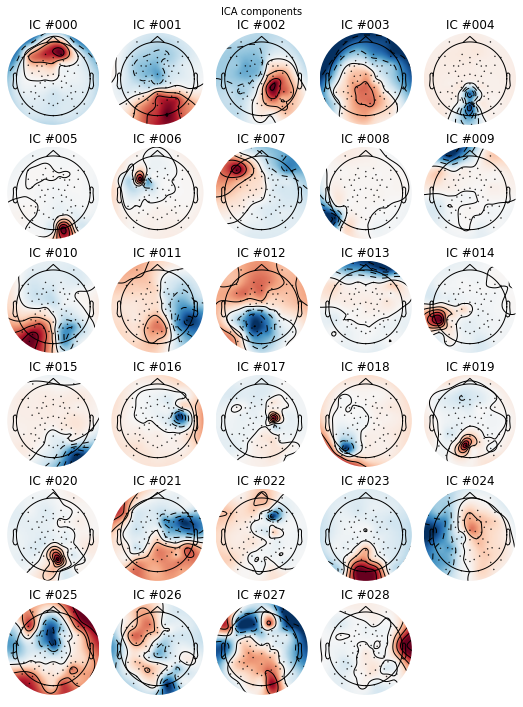

In [52]:
ica.plot_components(picks=range(29), outlines='skirt');

Using matplotlib backend: Qt4Agg


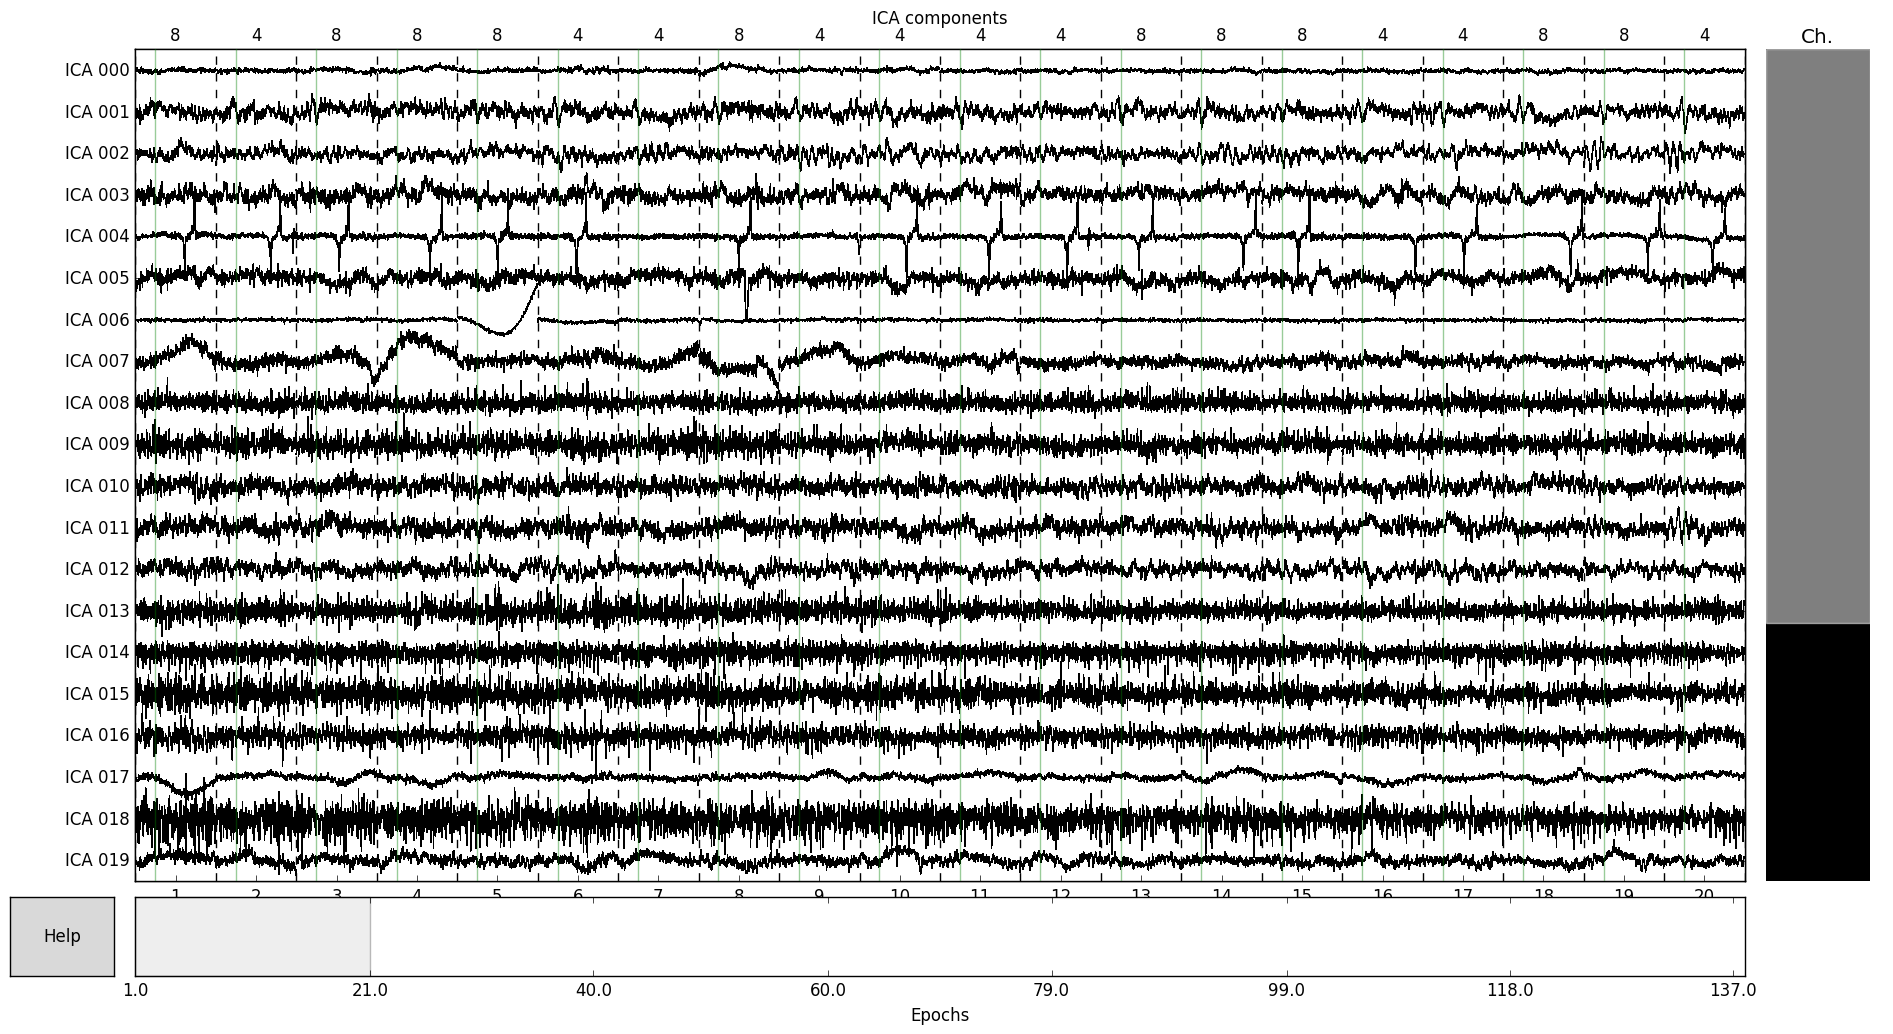

In [53]:
%matplotlib
ica.plot_sources(ep, picks=range(29), show=False)

Transforming to ICA space (29 components)
Zeroing out 5 ICA components


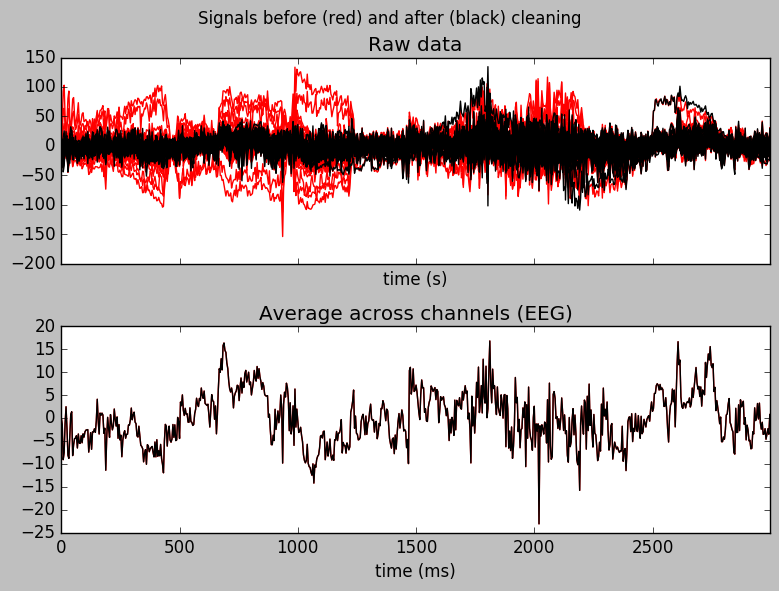

In [56]:
ica.plot_overlay(eeg_flt)

Transforming to ICA space (29 components)
Zeroing out 5 ICA components


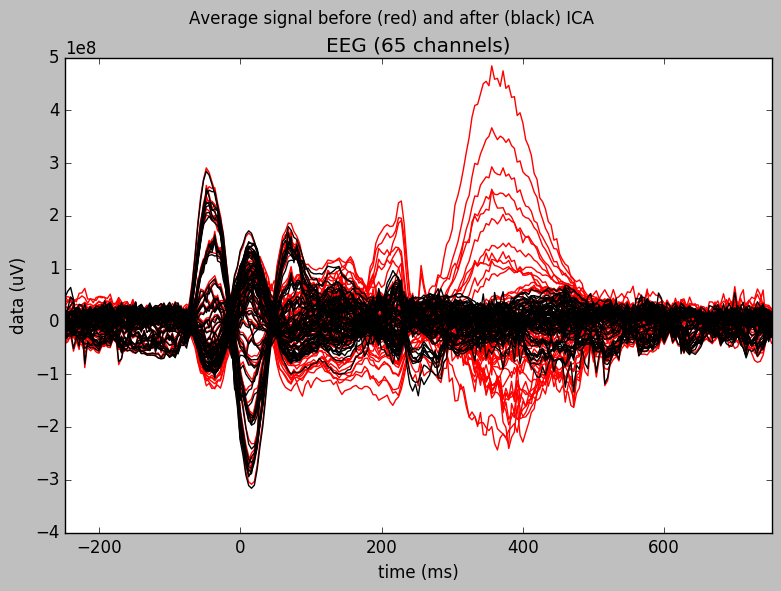

In [57]:
ica.plot_overlay(ep.average())

In [58]:
# usuwamy zaznaczone komponenty
ep = ica.apply(ep)

Transforming to ICA space (29 components)
Zeroing out 5 ICA components


In [69]:
plt.plot(ep.times, ep._data[10,35, :])

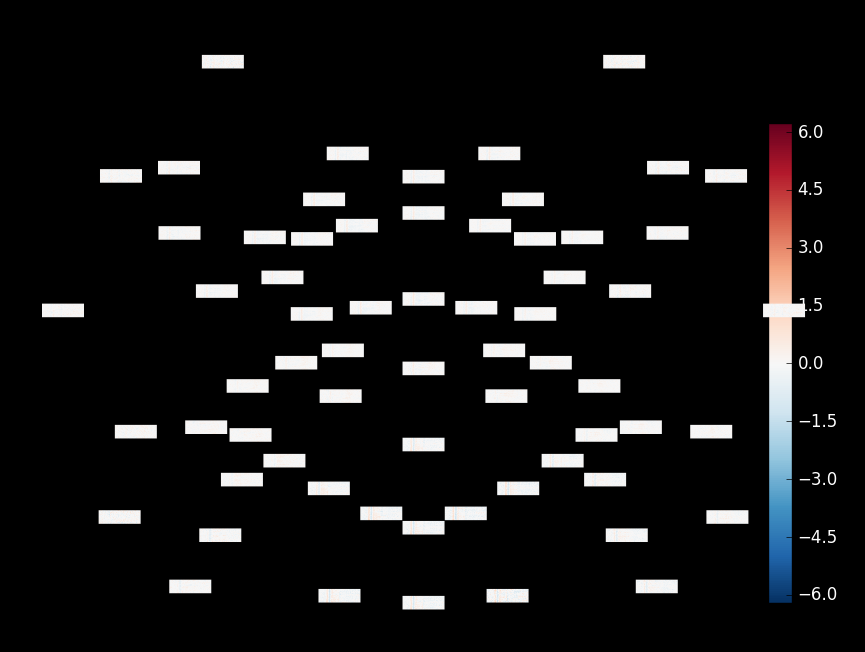

In [70]:
# zobaczmy jak teraz wyglądają obrazki trialo-erpów
ep.plot_topo_image(sigma=3)

# ERPs

In [71]:
ep['face']._data.shape

(68, 65, 251)

In [72]:
evkd = ep.average()

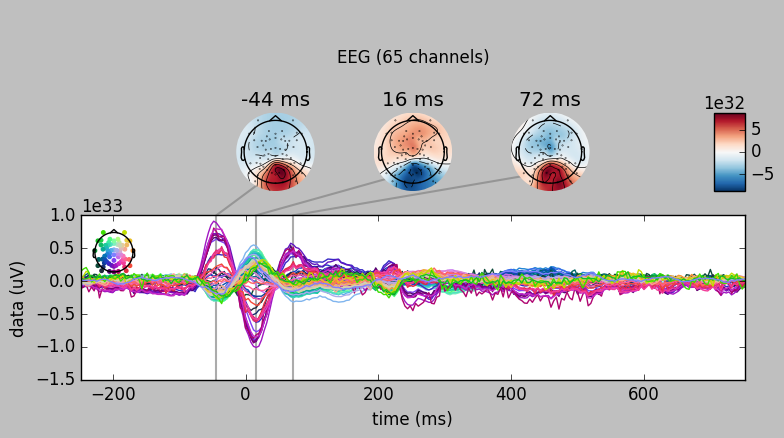

In [73]:
evkd.plot_joint()

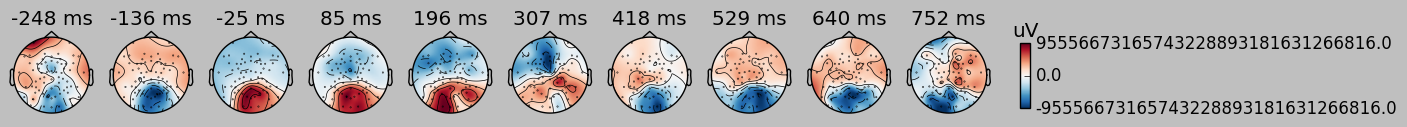

In [74]:
evkd.plot_topomap()

C:\Miniconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


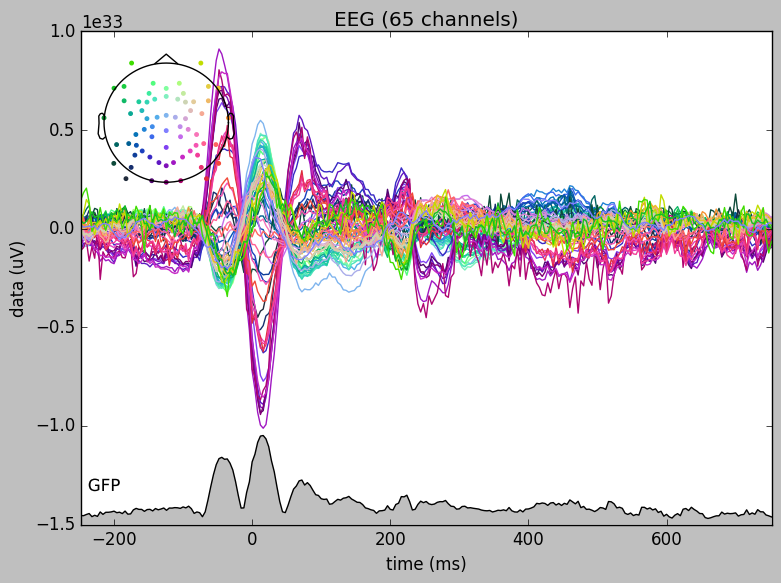

In [76]:
evkd.plot(spatial_colors=True, gfp=True)